## Writing analysis using MDAnalysis - Hydrogen bonds in Ethanol

This notebook explains how to analyse a molecular dynamics trajectory and count and visualise the hydrogen bonds present.

Hydrogen bonds are massively important in problems such as self assembly, and are formed between three atoms
 - the acceptor, who forms a strong nonbonded interaction with...
 - the hydrogen, who is connected via covalent bond to...
 - the donor

We will use a definition of a Hydrogen-Acceptor distances of less than 3.0 Angstroms and a Acceptor-Hydrogen-Donor angle of greater than 130 degrees.  We can therefore easily count and visualise the population of hydrogen bonds using simple geometry.

To do this we will use Python, and in particular the MDAnalysis package.

This will require version 0.16.2 or greater of MDAnalysis.

To start with, we will create a `Universe` object.  This is created from the .gro file from our Gromacs simulation, but could be made from practically any format of molecular dynamics simulation.

The "`guess_bonds`" keyword here tells MDAnalysis to guess the bonds between atoms when it loads the coordinates.  This is necessary as gro files carry no record of the connectivity between atoms.

In [1]:
import MDAnalysis as mda

u = mda.Universe('eth.gro', guess_bonds=True)

The `Universe` object acts as the nexus of analysis we will perform.
From this we will access information about the atoms, bonds and coordinates from our trajectory.

### Selecting atoms

Firstly, we want to select some atoms, but I can't remember what I called them.  I can quickly check by looking at the set of the types and names of the atoms.

In [2]:
print set(u.atoms.names)
print set(u.atoms.types)

set(['1H2', '3H1', '1H1', 'OH', '2H1', '2H2', 'HO', 'C2', 'C1'])
set(['H', 'C', 'O'])


I can then select atoms based on their name.  This creates an "AtomGroup".  This object holds an array of Atoms, and does many cool things.....

In [3]:
H = u.select_atoms('name HO')
H

<AtomGroup with 1473 atoms>

Among the many cool things AtomGroups can do, is provide the positions and velocities of the atoms.  These are given as a numpy array.

In [4]:
print H.positions
print
print H.velocities

[[ 50.79000092   9.5         45.38000107]
 [ 42.67000198  12.10999966   4.30999994]
 [  0.97999996   2.91000009  28.32999992]
 ..., 
 [ 15.55999947  51.40999603  32.42000198]
 [  1.41000009  41.45999908  18.71999931]
 [  5.36000013  49.27000046  50.87999725]]

[[ 13.48700047  12.28199959  -2.28699994]
 [ -7.4989996    8.77300072   4.42400026]
 [  1.82200003 -12.46500015  11.04599953]
 ..., 
 [  3.36299992   1.08899999   4.11500025]
 [ 22.60099792  -4.78800011   8.12100029]
 [ -2.07599998  -0.824        1.95700002]]


All OH atoms can be acceptors in hydrogen bonds, so we'll create an AtomGroup of those too

In [5]:
acc = u.select_atoms('name OH')
acc

<AtomGroup with 1473 atoms>

We also want to have a group representing the donor for each hydrogen.
For our system, this is identical to the selection of donors, but this is not true for all systems.  
A more correct way of making this selection is to use a list comprehension, choosing the first (and only) atom which is bonded to each hydrogen.

In [6]:
donors = sum([at.bonded_atoms[0] for at in H])

donors

<AtomGroup with 1473 atoms>

### Distance calculations

We want to now calculate distances between hydrogens and acceptors to see who is close enough to form a hydrogen bonds.  We could manipulate the position arrays in numpy, however MDAnalysis has some built in functions which are fast and do many common analysis tasks.

The first of these is `distance_array`.  This calculates all pairwise distances between 2 arrays of positions.  This therefore creates a (n x m) array from 2 arrays of length n and m.

We will pass this the positions of all our hydrogens and acceptors.

In [7]:
from MDAnalysis.lib.distances import distance_array

d = distance_array(H.positions, acc.positions)

print type(d)
print d.shape

<type 'numpy.ndarray'>
(1473, 1473)


There is a slight problem however, in that naively calculating all pairwise distances neglects the fact that our system has periodic boundaries in all three dimensions.  This leads to some distances being larger than is technically possible in this geometry.

In [8]:
print d.max()

84.3116245618


In [9]:
print u.dimensions

[ 52.23249817  52.23249817  52.23249817  90.          90.          90.        ]


However we can easily take account of periodic boundaries by passing the dimensions of the system to the distance_array function!

In [10]:
d = distance_array(H.positions, acc.positions, box=u.dimensions)

print d.max()

44.8677334147


We are then interested in any pairs that are less than 4 Angstroms apart.  This is easily done using numpy.where.  This then creates two arrays of indices of atoms.  One arrays refers to the Hydrogen indices, the other the indices of the Acceptors.

In [11]:
import numpy as np

Hidx, Aidx = np.where(d < 3.0)

print Hidx
print Aidx

[   0    0    1 ..., 1471 1472 1472]
[   0 1378    1 ..., 1471 1314 1472]


There's one final complication, this has also calculated the distance between atoms that are bonded.  This is visible as the diagonal of the array is consistently less than 1 Angstrom.

In [12]:
print d.diagonal()

[ 0.94583419  0.94583402  0.94984229 ...,  0.94556636  0.94836715
  0.94503941]


We can filter out these results by setting them to a high value, and remaking our index arrays.  

Another approach would be to apply a minimum distance critera of slightly larger than a bond length ie. (1.05 < d < 3.0)

In [13]:
d[np.diag_indices_from(d)] = 100.0

Hidx, Aidx = np.where(d < 3.0)

print Hidx
print Aidx

[   0    1    2 ..., 1470 1471 1472]
[1378 1337  202 ...,   30 1219 1314]


Now we've identified Hydrogen-Acceptor pairs with a small enough distance, we want to calculate the Donor-Hydrogen-Acceptor angle.  For this there is another handy function, `calc_angles`.  This calculates the angle in radians between triplets of points.

In the upcoming use, this will calculate the angle between `donors.positions[Hidx][0]`, `H.positions[Hidx][0]` and `acc.positions[Aidx][0]`

In [14]:
from MDAnalysis.lib.distances import calc_angles

a = calc_angles(donors.positions[Hidx], H.positions[Hidx], acc.positions[Aidx], box=u.dimensions)

print a
print a.shape

[ 3.00201938  2.77967765  2.63056263 ...,  2.82410089  2.78503343
  2.94779518]
(1526,)


We now want to filter out the angles which are smaller than 130 degrees.  Again numpy.where can do this

In [15]:
a_crit = np.deg2rad(130.0)
hbonds = np.where(a > a_crit)[0]
print len(hbonds)
print Hidx[hbonds]
print Aidx[hbonds]

1401
[   0    1    2 ..., 1470 1471 1472]
[1378 1337  202 ...,   30 1219 1314]


So we've identified 1,401 hydrogen bonds in our system, which with 1,473 ethanol molecules seems reasonable.  We can also see the identity of who is bonded by slicing our index arrays by the positions where the angle criteria was met.

In [16]:
print Hidx[hbonds]
print Aidx[hbonds]

[   0    1    2 ..., 1470 1471 1472]
[1378 1337  202 ...,   30 1219 1314]


### Plotting the bonds

Finally, we can try and understand the hydrogen bonds better by plotting the distribution of angles and distances.

In [17]:
a = np.rad2deg(a)

In [18]:
histogram, xedges, yedges = np.histogram2d(d[Hidx, Aidx], a,
                                           bins=40,
                                           range=[[1.5, 3.0], [60.0, 180.0]])
print histogram
print histogram.max()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  4. ...,  0.  0.  0.]
 [ 1.  3.  1. ...,  0.  0.  0.]
 [ 1.  0.  5. ...,  0.  0.  0.]]
23.0


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

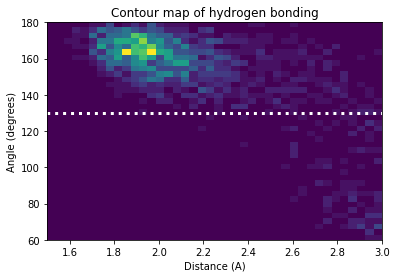

In [20]:
# define boundaries of image
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# plot the histogram
plt.cla()
plt.imshow(histogram.T, extent=extent,
           origin='lower', aspect='auto',
           interpolation='none')

# plot the geometric definition of hbonds we used
plt.plot([0.0, 3.0], [130.0, 130.0], color='w', ls=':', lw=3.0)

plt.xlim((1.5, 3.0))
plt.ylim((60.0, 180.0))

plt.title('Contour map of hydrogen bonding')
plt.xlabel('Distance (A)')
plt.ylabel('Angle (degrees)')